In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(measurement.date)).scalar()
latest_date

'2017-08-23'

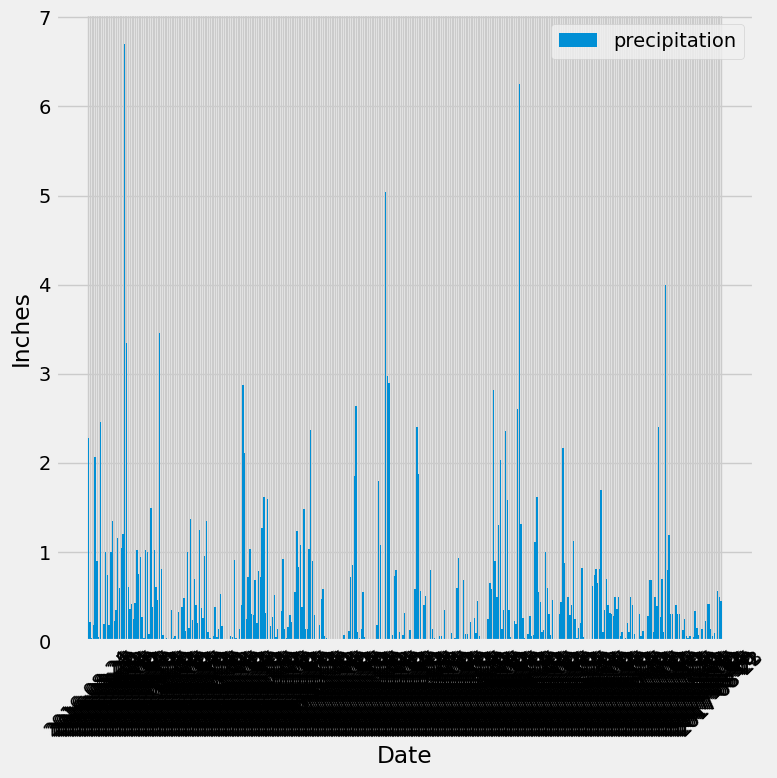

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(func.max(measurement.date)).scalar()
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 8))
plt.bar(df['Date'], df['Precipitation'], label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics_df = df['Precipitation'].describe()
summary_statistics_df

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station).label('station_count')) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()) \
    .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(measurement.tobs).label('lowest_temperature'),
                                  func.max(measurement.tobs).label('highest_temperature'),
                                  func.avg(measurement.tobs).label('average_temperature')) \
    .filter(measurement.station == most_active_station_id) \
    .all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

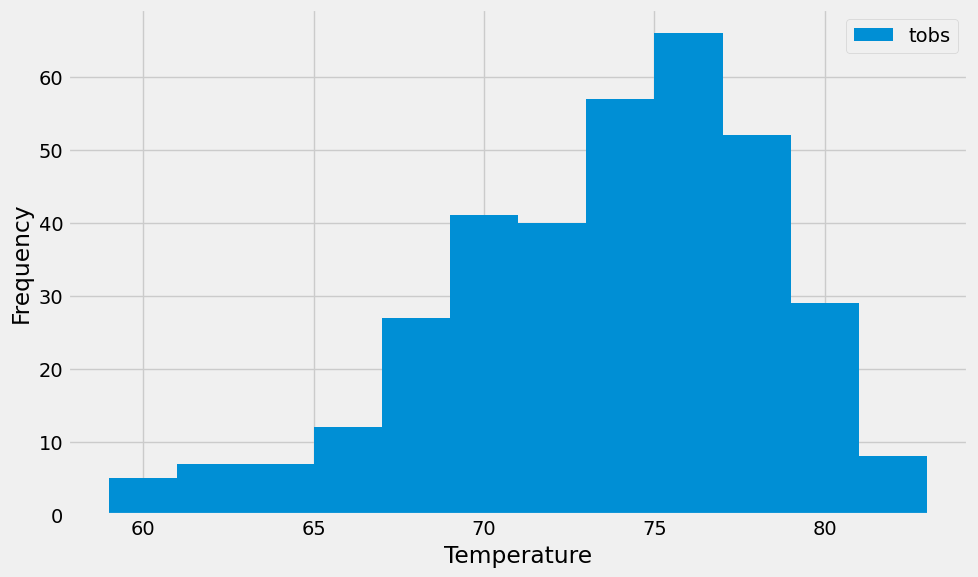

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_results = session.query(measurement.date, measurement.tobs) \
    .filter(measurement.station == most_active_station_id) \
    .filter(measurement.date >= one_year_ago) \
    .all()
temperature_df = pd.DataFrame(temperature_results, columns=['Date', 'Temperature'])
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()